In [66]:
#Import libraries
import pandas as pd
import numpy as np
import pickle
from ucimlrepo import fetch_ucirepo 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, r2_score
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from scipy.io import arff
import zipfile
import os

In [67]:
# Data Loader loads data from UCI-ML Repo
def load_dataset():
    # fetch dataset
    obesityDB = fetch_ucirepo(id=544) 

    # data (as pandas dataframes) 
    x = obesityDB.data.features 
    y = obesityDB.data.targets 
    z = obesityDB.data.original

    # metadata 
    print(obesityDB.metadata) 

    # variable information 
    print(obesityDB.variables)

    return x, y, z

# UCI-ML Repo Provides us with 3 Pandas DF inherently:
# 1. features (contains only the features)
# 2. targets (the targets to be preddicted)
# 3. original (contains both features and targets)
features, targets, original = load_dataset()

{'uci_id': 544, 'name': 'Estimation of obesity levels based on eating habits and physical condition ', 'repository_url': 'https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition', 'data_url': 'https://archive.ics.uci.edu/static/public/544/data.csv', 'abstract': 'This dataset include data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. ', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 2111, 'num_features': 16, 'feature_types': ['Integer'], 'demographics': ['Gender', 'Age'], 'target_col': ['NObeyesdad'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Tue Dec 19 2023', 'dataset_doi': '10.24432/C5H31Z', 'creators': [], 'intro_paper': {'title': 'Dataset f

In [68]:
# X = pd.DataFrame(X)
# y = pd.Series(y)

# Display the first few rows of the features dataframe
print("Head of Features:")
print(X.head())

# Display basic details about the features dataframe
print("\nData Details:")
print(X.info())

# Display basic statistics about the target variable
print("\nTarget Variable Statistics:")
print(y.describe())

Head of Features:
   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS  
0  Public_Transportation  
1  Public_Transportation  
2  Public_Transportation  
3                Walking  
4  Public_Transportatio

In [69]:
# This function performs a missing value analysis on each column of the dataset, helps you decide on what to do in cleaning process
def null_check(df):
    null_columns = []
    for column in df.columns:
        print("Column Name:", column)
        print("Column DataType:", df[column].dtype)
        if df[column].dtype != 'float64':
            print("Column unique values:", df[column].unique())
        print("Column has null:", df[column].isnull().any())
        if df[column].isnull().any() == True:
            print("Column Null Count:", df[column].isnull().sum())
            null_columns.append(column)
        print("\n")
    return null_columns

null_cols = null_check(original)

Column Name: Gender
Column DataType: object
Column unique values: ['Female' 'Male']
Column has null: False


Column Name: Age
Column DataType: float64
Column has null: False


Column Name: Height
Column DataType: float64
Column has null: False


Column Name: Weight
Column DataType: float64
Column has null: False


Column Name: family_history_with_overweight
Column DataType: object
Column unique values: ['yes' 'no']
Column has null: False


Column Name: FAVC
Column DataType: object
Column unique values: ['no' 'yes']
Column has null: False


Column Name: FCVC
Column DataType: float64
Column has null: False


Column Name: NCP
Column DataType: float64
Column has null: False


Column Name: CAEC
Column DataType: object
Column unique values: ['Sometimes' 'Frequently' 'Always' 'no']
Column has null: False


Column Name: SMOKE
Column DataType: object
Column unique values: ['no' 'yes']
Column has null: False


Column Name: CH2O
Column DataType: float64
Column has null: False


Column Name: SCC
C

In [70]:
# This function drops any null columns and missing values
# This is where you decide whether to remove NULL rows (which will reduce the size of Dataset) or remove NULL columns entirely. You can also choose a combination of both.
def clean_data(df, drop_columns, missing_value):
    # Remove unnecessary columns
    df.drop(drop_columns, axis=1, inplace=True)
    # Drop rows with any missing values
    if missing_value == False:
        df.dropna(inplace=True)
    else:
        df.fillna(missing_value, inplace=True)
    return df

clean_data(original,null_cols,False)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [71]:
# Transforms categorical and numberical data into numerical data
def transform_data(df):
    # Encode categorical variables
    label_encoder = LabelEncoder()
    print("Categorical columns:", df.select_dtypes(include=['object']).columns)
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = label_encoder.fit_transform(df[col])
    
    # Standardize numerical features
    scaler = StandardScaler()
    print("Numerical columns:", df.select_dtypes(include=['float64', 'int64']).columns)
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numerical_cols) > 0:
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

transform_data(original)

Categorical columns: Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')
Numerical columns: Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,-0.522124,-0.875589,-0.862558,1,0,-0.785019,0.404153,2,0,-0.013073,0,-1.188039,0.561997,3,3,1
1,0,-0.522124,-1.947599,-1.168077,1,0,1.088342,0.404153,2,1,1.618759,1,2.339750,-1.080625,2,3,1
2,1,-0.206889,1.054029,-0.366090,1,0,-0.785019,0.404153,2,0,-0.013073,0,1.163820,0.561997,1,3,1
3,1,0.423582,1.054029,0.015808,0,0,1.088342,0.404153,2,0,-0.013073,0,1.163820,-1.080625,1,4,5
4,1,-0.364507,0.839627,0.122740,0,0,-0.785019,-2.167023,2,0,-0.013073,0,-1.188039,-1.080625,2,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,-0.525774,0.097045,1.711763,1,1,1.088342,0.404153,2,0,-0.456705,0,0.783135,0.407996,2,3,4
2107,0,-0.367195,0.502844,1.800914,1,1,1.088342,0.404153,2,0,-0.004702,0,0.389341,-0.096251,2,3,4
2108,0,-0.281909,0.541672,1.798868,1,1,1.088342,0.404153,2,0,0.075361,0,0.474971,-0.019018,2,3,4
2109,0,0.007776,0.404927,1.785780,1,1,1.088342,0.404153,2,0,1.377801,0,0.151471,-0.117991,2,3,4


In [72]:
# Performs data splitting on a 80:20 ratio
def split_data(df, target_name):
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Performs training and evaluation
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions))
    print("Accuracy:", accuracy_score(y_test, predictions))

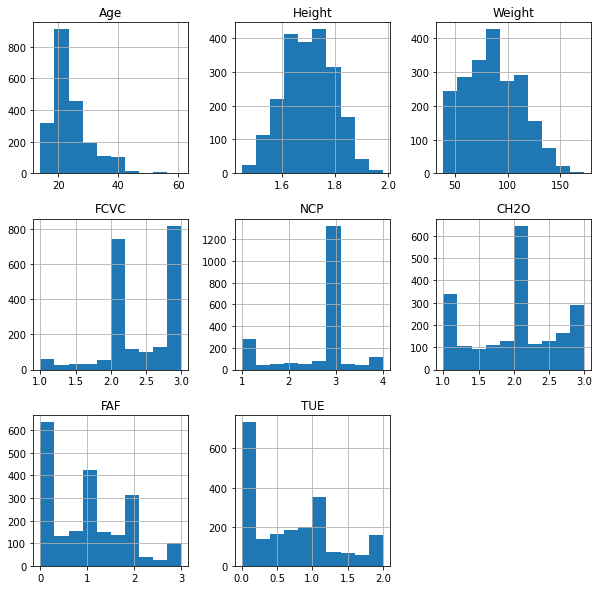

In [73]:
# Creates histograms for categorical data
def plot_histograms(df):
    df.hist(figsize=(10, 10))
    plt.show()

# Creates boxplot for numerical data
def plot_boxplots(df):
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        sns.boxplot(x=df[col])
        plt.show()

plot_histograms(X)

In [74]:
# Master Workflow, combines and manages all the workflow from one place
# Specifically Tailored for Mushroom Dataset
def master_workflow():
    features, targets, original = load_dataset()
    null_cols = null_check(original)
    original = clean_data(original,null_cols,False)
    original = transform_data(original)
    plot_histograms(original)
    plot_boxplots(original)
    X_train, X_test, y_train, y_test = split_data(original, targets.columns[0])
    train_and_evaluate(X_train, X_test, y_train, y_test)

{'uci_id': 544, 'name': 'Estimation of obesity levels based on eating habits and physical condition ', 'repository_url': 'https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition', 'data_url': 'https://archive.ics.uci.edu/static/public/544/data.csv', 'abstract': 'This dataset include data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. ', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 2111, 'num_features': 16, 'feature_types': ['Integer'], 'demographics': ['Gender', 'Age'], 'target_col': ['NObeyesdad'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Tue Dec 19 2023', 'dataset_doi': '10.24432/C5H31Z', 'creators': [], 'intro_paper': {'title': 'Dataset f

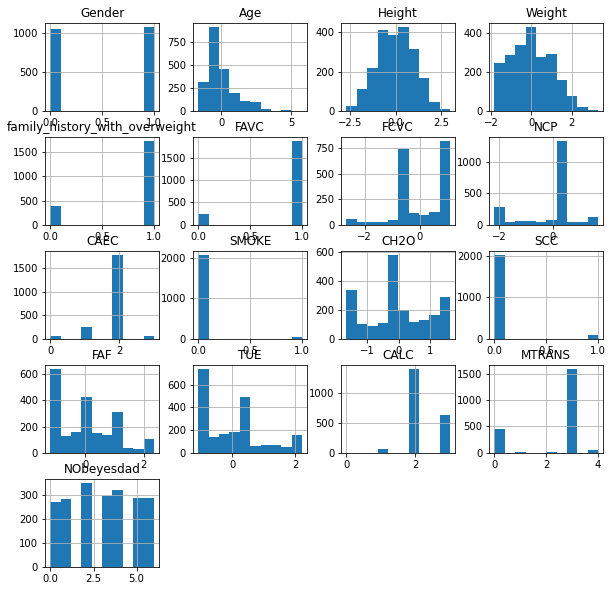

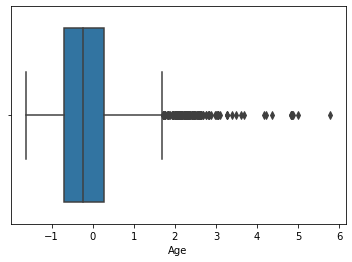

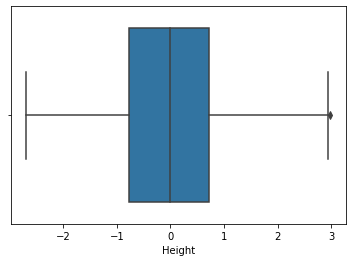

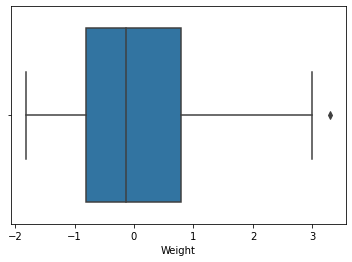

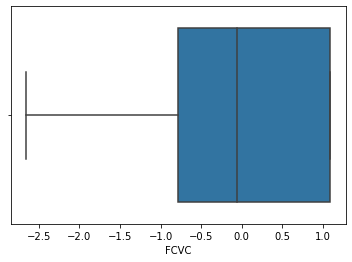

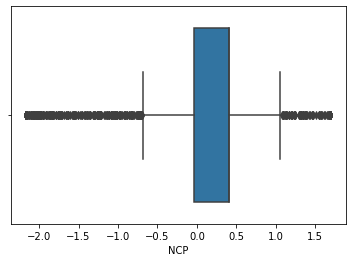

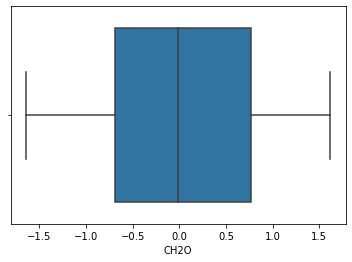

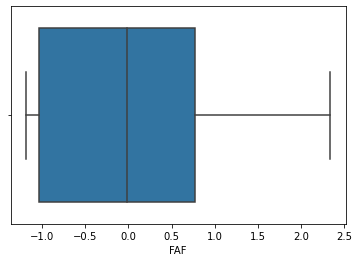

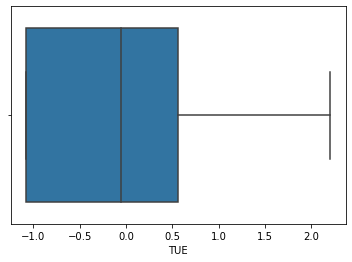

              precision    recall  f1-score   support

           0       0.76      0.96      0.85        56
           1       0.80      0.39      0.52        62
           2       0.85      0.92      0.88        78
           3       0.86      0.98      0.92        58
           4       0.97      1.00      0.98        63
           5       0.73      0.71      0.72        56
           6       0.73      0.74      0.73        50

    accuracy                           0.82       423
   macro avg       0.81      0.82      0.80       423
weighted avg       0.82      0.82      0.81       423

Accuracy: 0.8203309692671394


In [75]:
master_workflow()

In [76]:
def generate_summary_statistics(df):
    """
    Generate summary statistics for a given DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame.

    Returns:
    DataFrame: Summary statistics DataFrame.
    """
    # Compute mean
    mean = df.mean()

    # Compute mode
    mode = df.mode().iloc[0]  # Mode may have multiple values, so we take the first one

    # Compute median
    median = df.median()

    # Compute quartiles
    quartiles = df.quantile([0.25, 0.5, 0.75])

    # Compute minimum and maximum
    minimum = df.min()
    maximum = df.max()

    # Combine the results into a DataFrame for easier visualization
    summary_df = pd.DataFrame({
        'Mean': mean,
        'Mode': mode,
        'Median': median,
        'Q1': quartiles.loc[0.25],
        'Q2': quartiles.loc[0.5],
        'Q3': quartiles.loc[0.75],
        'Minimum': minimum,
        'Maximum': maximum
    })

    return summary_df

# Assuming your dataset is already loaded into a pandas DataFrame df
# Call the function and pass your DataFrame as input
summary_statistics = generate_summary_statistics(df)

# Print or display the summary DataFrame
print(summary_statistics)

                                        Mean      Mode    Median        Q1  \
Gender                          5.059214e-01  1.000000  1.000000  0.000000   
Age                            -4.823567e-16 -0.994977 -0.241897 -0.688066   
Height                         -6.476213e-16 -0.017981 -0.012632 -0.768388   
Weight                         -1.786349e-15 -0.251521 -0.136951 -0.806291   
family_history_with_overweight  8.176220e-01  1.000000  1.000000  1.000000   
FAVC                            8.839413e-01  1.000000  1.000000  1.000000   
FCVC                            2.861020e-16  1.088342 -0.062834 -0.785019   
NCP                            -6.844359e-16  0.404153  0.404153 -0.034570   
CAEC                            1.859308e+00  2.000000  2.000000  2.000000   
SMOKE                           2.084320e-02  0.000000  0.000000  0.000000   
CH2O                            3.811888e-16 -0.013073 -0.013073 -0.690589   
SCC                             4.547608e-02  0.000000  0.000000

In [59]:
# Assuming df is your DataFrame
# Compute Z-score for each column
z_scores = (df - df.mean()) / df.std()

# Define threshold for outliers (e.g., 3 standard deviations)
threshold = 3

# Detect outliers
outliers = np.abs(z_scores) > threshold

# Print rows with outliers
print(df[outliers.any(axis=1)])

      Gender       Age    Height    Weight  family_history_with_overweight  \
1          0 -0.522124 -1.947599 -1.168077                               1   
11         0 -0.522124  0.196421 -0.251521                               1   
15         0 -0.364507 -0.017981 -0.786178                               1   
18         0  0.896435  0.089220 -0.175141                               1   
21         0  4.364024 -0.125182  0.015808                               1   
...      ...       ...       ...       ...                             ...   
1676       1  1.004300  2.286840  1.656690                               1   
1727       1  1.086470  1.887323  1.549566                               1   
1728       1  1.038168  2.229370  1.620285                               1   
1763       1  1.085460  1.577652  1.469996                               1   
1764       1  1.084035  1.512977  1.504217                               1   

      FAVC      FCVC       NCP  CAEC  SMOKE      CH2O  SCC     

In [77]:
# Assuming x and y are your independent and dependent variables
model = LinearRegression()
model.fit(X, y)

# Get coefficients and intercept
slope = model.coef_
intercept = model.intercept_

# Print slope and intercept
print("Slope:", slope)
print("Intercept:", intercept)

ValueError: could not convert string to float: 'Female'

In [78]:
from sklearn.cluster import KMeans

# Assuming X is your feature matrix
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

# Get cluster labels and centroids
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Print cluster labels
print("Cluster Labels:", cluster_labels)


ValueError: could not convert string to float: 'Female'

In [79]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression  # Replace with your chosen model

# Assuming you have your features X and targets y loaded already

# Define the model
model = LogisticRegression()  # Replace with your chosen model

# Define the cross-validation method
# For example, using KFold with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=kf)

# Print the cross-validation scores
print("Cross-validation Scores:", cv_scores)

# Calculate and print the mean and standard deviation of the cross-validation scores
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())

Cross-validation Scores: [nan nan nan nan nan]
Mean CV Score: nan
Standard Deviation of CV Scores: nan


C:\Users\buu_7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\buu_7\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\buu_7\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1508, in fit
    X, y = self._validate_data(
  File "C:\Users\buu_7\anaconda3\lib\site-packages\sklearn\base.py", line 581, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\buu_7\anaconda3\lib